In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from keras.layers import Dense
import pandas as pd

In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Waste_Classification/Dataset_Resized"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
batch_size = 32
img_height = 150
img_width = 150
data_dir = '/content/drive/MyDrive/Waste_Classification/Dataset_Resized'

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2¿3,
  subset="training",
  shuffle=True,
  seed=42,
  smart_resize=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 3496 files for training.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  shuffle=True,
  seed=42,
  smart_resize=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 873 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 23
Number of test batches: 5


In [ ]:
class_names = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(class_names)
print(numClasses)

['Aluminium', 'Cardboard', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']
9


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

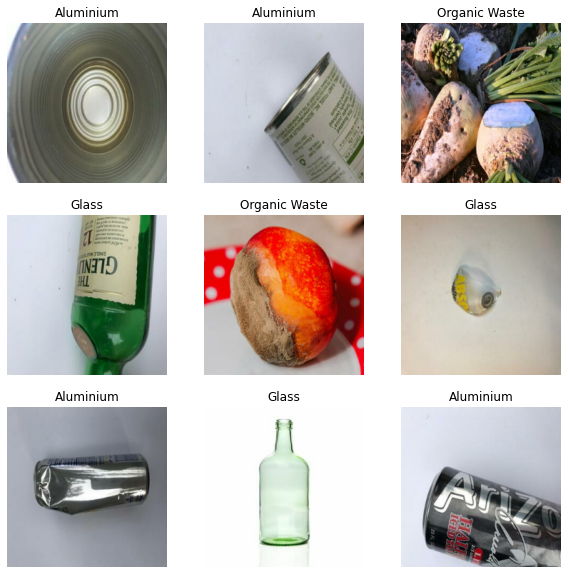

In [ ]:
#class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])

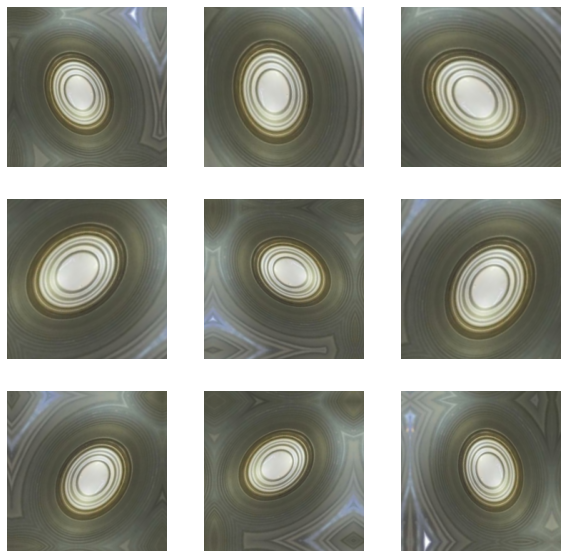

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [ ]:
#IMG_SIZE = (224, 224)
#IMG_SHAPE = IMG_SIZE + (3,)
#base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(150, 150,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in base_model.layers[:-6]:
  layers.trainable=False

last_output = base_model.layers[-1].output
x = tf.keras.layers.Dropout(0.2) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.2) (x)
x = tf.keras.layers.Dense(numClasses)(x)

model = tf.keras.Model(inputs=base_model.input,outputs=x)

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 960)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [ ]:
prediction_layer = tf.keras.layers.Dense(9)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 9)


In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 960)               0         
                                                                 
 dense_2 (Dense)             (None, 9)                 8649

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

23/23 [==============================] - 5s 73ms/step - loss: 8.4085 - accuracy: 0.1108
initial loss: 8.41
initial accuracy: 0.11


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
110/110 [==============================] - 15s 97ms/step - loss: 8.4779 - accuracy: 0.1670 - val_loss: 7.4067 - val_accuracy: 0.2216
Epoch 2/10
110/110 [==============================] - 11s 94ms/step - loss: 7.4076 - accuracy: 0.2363 - val_loss: 6.0120 - val_accuracy: 0.2651
Epoch 3/10
110/110 [==============================] - 11s 93ms/step - loss: 6.5155 - accuracy: 0.2637 - val_loss: 4.9262 - val_accuracy: 0.3394
Epoch 4/10
110/110 [==============================] - 11s 93ms/step - loss: 5.6799 - accuracy: 0.3215 - val_loss: 4.6840 - val_accuracy: 0.3562
Epoch 5/10
110/110 [==============================] - 11s 93ms/step - loss: 5.2102 - accuracy: 0.3341 - val_loss: 4.4303 - val_accuracy: 0.3604
Epoch 6/10
110/110 [==============================] - 11s 93ms/step - loss: 5.3092 - accuracy: 0.3450 - val_loss: 4.4056 - val_accuracy: 0.3647
Epoch 7/10
110/110 [==============================] - 11s 93ms/step - loss: 4.9915 - accuracy: 0.3573 - val_loss: 4.0671 - val_accuracy:

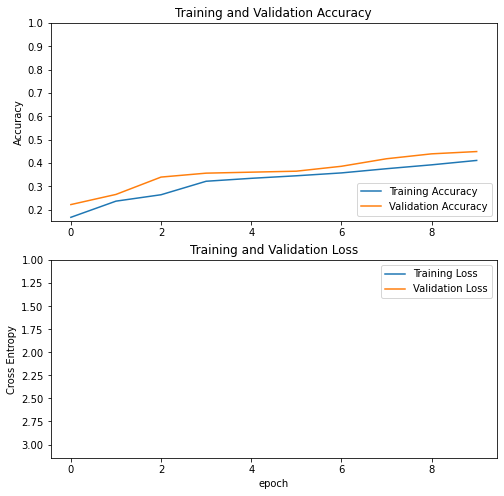

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 960)               0         
                                                                 
 dense_2 (Dense)             (None, 9)                 8649

In [ ]:
len(model.trainable_variables)

94

In [ ]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/50
110/110 [==============================] - 25s 121ms/step - loss: 3.9421 - accuracy: 0.4359 - val_loss: 2.9186 - val_accuracy: 0.4909
Epoch 11/50
110/110 [==============================] - 13s 111ms/step - loss: 3.8151 - accuracy: 0.4620 - val_loss: 2.8554 - val_accuracy: 0.5316
Epoch 12/50
110/110 [==============================] - 13s 110ms/step - loss: 3.6508 - accuracy: 0.4771 - val_loss: 2.6770 - val_accuracy: 0.5442
Epoch 13/50
110/110 [==============================] - 13s 111ms/step - loss: 3.3666 - accuracy: 0.5043 - val_loss: 2.7027 - val_accuracy: 0.5722
Epoch 14/50
110/110 [==============================] - 13s 115ms/step - loss: 3.3993 - accuracy: 0.5229 - val_loss: 2.9791 - val_accuracy: 0.5708
Epoch 15/50
110/110 [==============================] - 13s 111ms/step - loss: 3.3963 - accuracy: 0.5243 - val_loss: 2.6021 - val_accuracy: 0.6073
Epoch 16/50
110/110 [==============================] - 12s 109ms/step - loss: 3.2843 - accuracy: 0.5452 - val_loss: 2.4367 -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

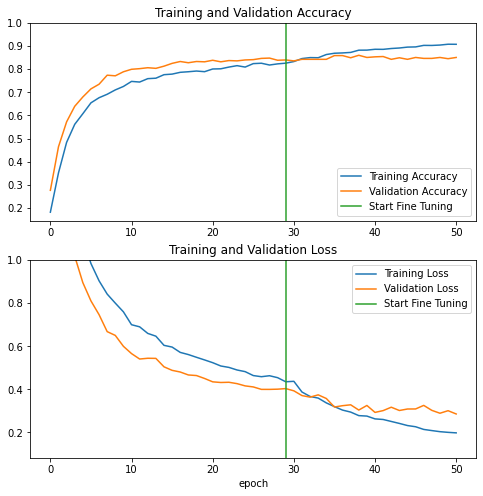

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 118ms/step - loss: 0.3499 - accuracy: 0.8500
Test accuracy : 0.8500000238418579
